# Auto Encoder

## Load Dataset

In [1]:
DATASET_NAME = 'dataset-5000'
TEST_DATASET_NAME = 'dataset-test'
BATCH_SIZE = 16
MODEL_PATH = 'model/cnn_residual'

import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from util import GeneratedDataset

trainset = GeneratedDataset(DATASET_NAME, transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = GeneratedDataset(TEST_DATASET_NAME, transforms.ToTensor())
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

## Define CNN based auto-encoder

- 64 * 64 * 3 image input = 12,288
- Cov3 with 32 channel, 3 * 3 * 3 * 32 = 864 parameters
- ReLU
- MaxPool -> 32 * 32 * 32 hidden state = 32768
- Cov3 with 64 channel, 32 * 3 * 3 * 64 = 18432 parameters
- ReLU
- MaxPool -> 16 * 16 * 64 hidden state = 16384
- Cov3 with 128 channel, 64 * 3 * 3 * 128 = 73728 parameters
- ReLU
- MaxPool -> 8 * 8 * 128 = 8192 hidden state
- Full connected 8192 -> **embedding size**

And the decoder works reversely.

In [2]:
# Define the autoencoder model with residual connections
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        residual = self.shortcut(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x += residual
        return x

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, embedding_size=32, dropout_rate=0.25):
        super(Autoencoder, self).__init__()
        self.embedding_size = embedding_size

        # Encoder
        self.encoder = nn.Sequential(
            ResidualBlock(3, 32),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(dropout_rate),
            ResidualBlock(32, 64),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(dropout_rate),
            ResidualBlock(64, 128),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(dropout_rate)
        )
        self.fc1 = nn.Linear(8 * 8 * 128, embedding_size)  # Fully connected layer to get 32-length embedding

        # Decoder
        self.fc2 = nn.Linear(embedding_size, 8 * 8 * 128)  # Fully connected layer to reshape back to 8x8x128
        self.decoder = nn.Sequential(
            ResidualBlock(128, 128),
            nn.Upsample(scale_factor=2),
            nn.Dropout(dropout_rate),
            ResidualBlock(128, 64),
            nn.Upsample(scale_factor=2),
            nn.Dropout(dropout_rate),
            ResidualBlock(64, 32),
            nn.Upsample(scale_factor=2),
            nn.Dropout(dropout_rate),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(encoded.size(0), -1)  # Flatten the tensor
        encoded = self.fc1(encoded)  # Get the embedding
        decoded = self.fc2(encoded)  # Reshape back to 8x8x128
        decoded = decoded.view(decoded.size(0), 128, 8, 8)
        decoded = self.decoder(decoded)
        return decoded, encoded

In [3]:
from util import train_model_steps, plot_model, count_parameters

def train_model(embedding_size=32, dropout_rate=0.25, learning_rate=1e-4, weight_decay=1e-5, num_epochs=20):
    # Initialize the model
    model = Autoencoder(embedding_size=embedding_size, dropout_rate=dropout_rate)
    print(f'Number of parameters: {count_parameters(model)}')

    model, train_losses, test_losses = train_model_steps(model, trainloader, testloader, learning_rate, weight_decay, num_epochs)
    # Save the model
    torch.save(model.state_dict(), f'{MODEL_PATH}/e{embedding_size}.pth')
    plot_model(model, train_losses, test_losses, testset)
    return model, train_losses, test_losses

## Evaluation

Testing with embedding size of (down from 8192)
- 4
- 8
- 16
- 32
- 64

Number of parameters: 832615
Epoch [1/20], Train Loss: 0.2557, Test Loss: 0.1594
Epoch [2/20], Train Loss: 0.1459, Test Loss: 0.1488
Epoch [3/20], Train Loss: 0.1363, Test Loss: 0.1415
Epoch [4/20], Train Loss: 0.1307, Test Loss: 0.1407
Epoch [5/20], Train Loss: 0.1265, Test Loss: 0.1440
Epoch [6/20], Train Loss: 0.1239, Test Loss: 0.1348
Epoch [7/20], Train Loss: 0.1219, Test Loss: 0.1303
Epoch [8/20], Train Loss: 0.1189, Test Loss: 0.1284
Epoch [9/20], Train Loss: 0.1160, Test Loss: 0.1277
Epoch [10/20], Train Loss: 0.1140, Test Loss: 0.1250
Epoch [11/20], Train Loss: 0.1127, Test Loss: 0.1249
Epoch [12/20], Train Loss: 0.1111, Test Loss: 0.1210
Epoch [13/20], Train Loss: 0.1105, Test Loss: 0.1221
Epoch [14/20], Train Loss: 0.1097, Test Loss: 0.1211
Epoch [15/20], Train Loss: 0.1091, Test Loss: 0.1206
Epoch [16/20], Train Loss: 0.1086, Test Loss: 0.1188
Epoch [17/20], Train Loss: 0.1085, Test Loss: 0.1190
Epoch [18/20], Train Loss: 0.1081, Test Loss: 0.1182
Epoch [19/20], Train Loss:

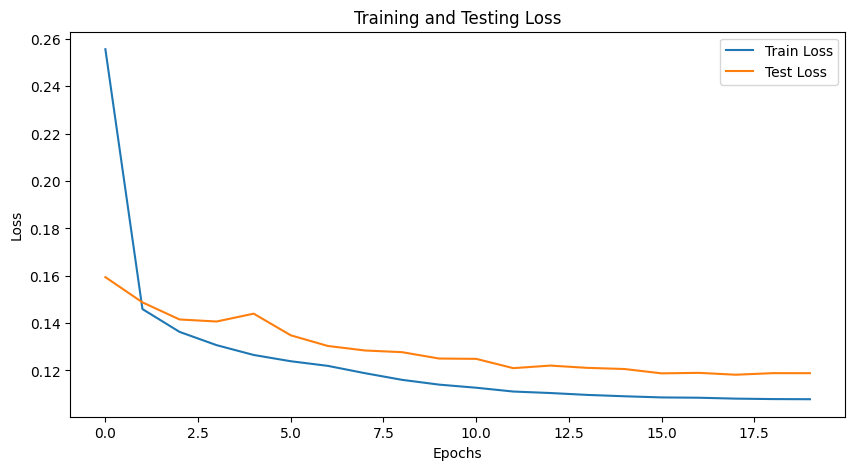

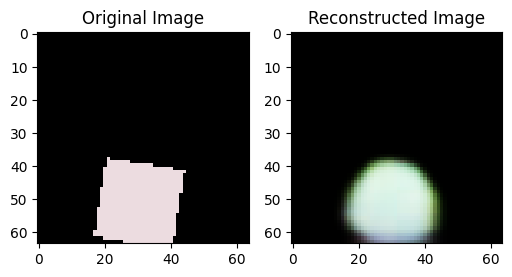

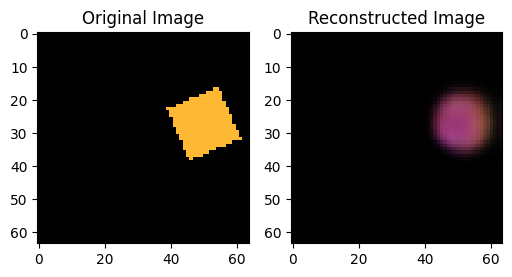

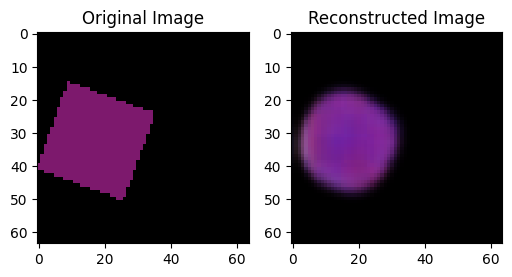

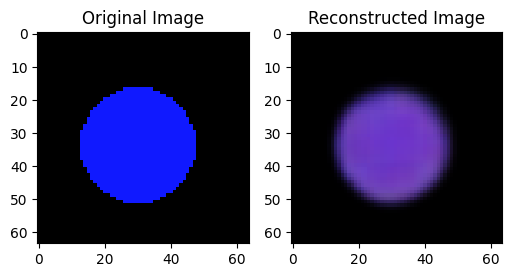

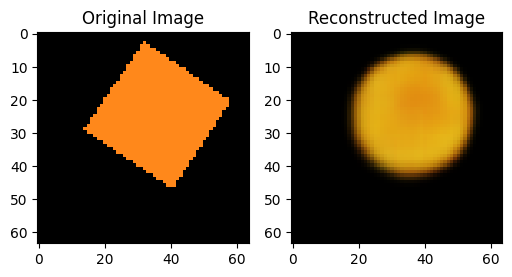

(Autoencoder(
   (encoder): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
     )
     (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (2): Dropout(p=0.1, inplace=False)
     (3): ResidualBlock(
       (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
     )
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): Dropout(p=0.1, inplace=False)
     (6): ResidualBlock(
       (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (relu): ReLU()
       (

In [4]:
train_model(embedding_size=4, dropout_rate=0.1)

Number of parameters: 898155
Epoch [1/20], Train Loss: 0.2342, Test Loss: 0.1562
Epoch [2/20], Train Loss: 0.1414, Test Loss: 0.1463
Epoch [3/20], Train Loss: 0.1324, Test Loss: 0.1392
Epoch [4/20], Train Loss: 0.1223, Test Loss: 0.1247
Epoch [5/20], Train Loss: 0.1108, Test Loss: 0.1151
Epoch [6/20], Train Loss: 0.1052, Test Loss: 0.1110
Epoch [7/20], Train Loss: 0.1019, Test Loss: 0.1092
Epoch [8/20], Train Loss: 0.0993, Test Loss: 0.1079
Epoch [9/20], Train Loss: 0.0977, Test Loss: 0.1081
Epoch [10/20], Train Loss: 0.0959, Test Loss: 0.1023
Epoch [11/20], Train Loss: 0.0939, Test Loss: 0.1011
Epoch [12/20], Train Loss: 0.0923, Test Loss: 0.0996
Epoch [13/20], Train Loss: 0.0911, Test Loss: 0.0971
Epoch [14/20], Train Loss: 0.0902, Test Loss: 0.0958
Epoch [15/20], Train Loss: 0.0895, Test Loss: 0.0961
Epoch [16/20], Train Loss: 0.0892, Test Loss: 0.0945
Epoch [17/20], Train Loss: 0.0888, Test Loss: 0.0948
Epoch [18/20], Train Loss: 0.0885, Test Loss: 0.0947
Epoch [19/20], Train Loss:

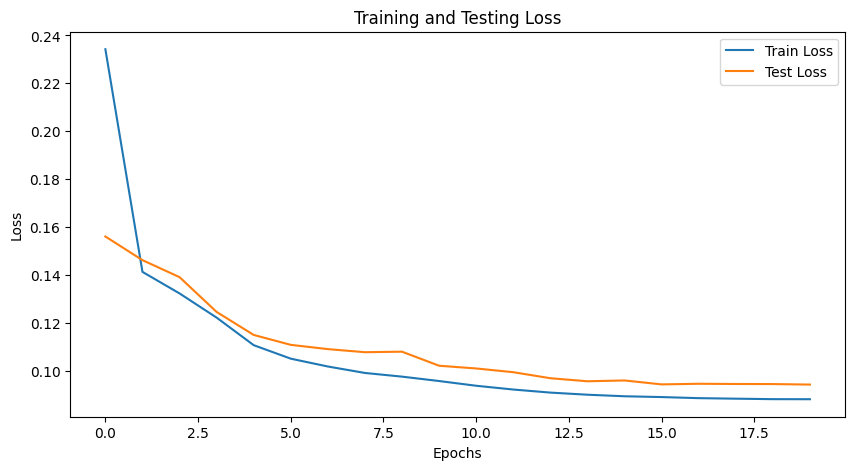

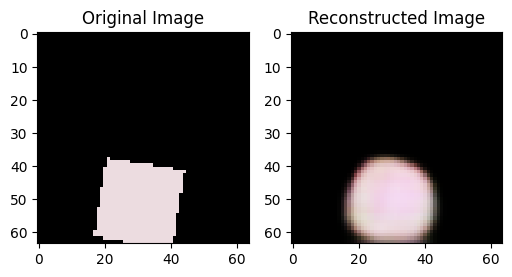

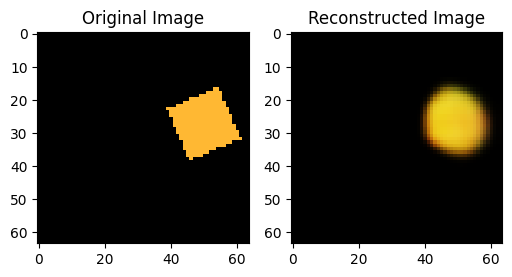

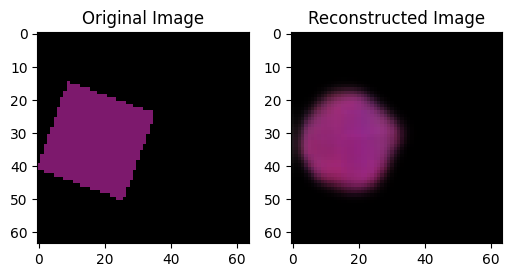

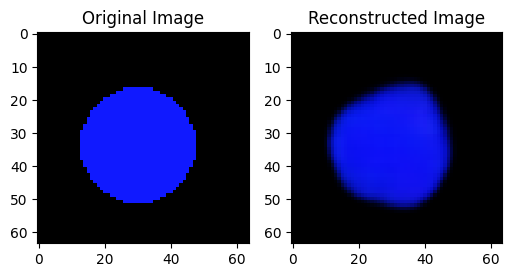

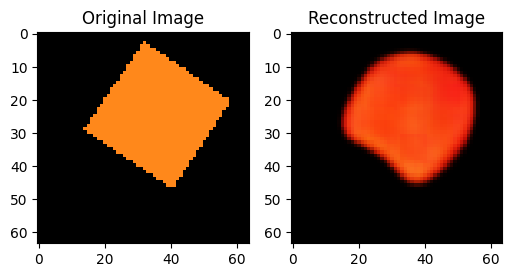

(Autoencoder(
   (encoder): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
     )
     (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (2): Dropout(p=0.1, inplace=False)
     (3): ResidualBlock(
       (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
     )
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): Dropout(p=0.1, inplace=False)
     (6): ResidualBlock(
       (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (relu): ReLU()
       (

In [5]:
train_model(embedding_size=8, dropout_rate=0.1)

Number of parameters: 1029235
Epoch [1/20], Train Loss: 0.2245, Test Loss: 0.1474
Epoch [2/20], Train Loss: 0.1371, Test Loss: 0.1373
Epoch [3/20], Train Loss: 0.1248, Test Loss: 0.1181
Epoch [4/20], Train Loss: 0.1089, Test Loss: 0.1099
Epoch [5/20], Train Loss: 0.1023, Test Loss: 0.1066
Epoch [6/20], Train Loss: 0.0984, Test Loss: 0.1013
Epoch [7/20], Train Loss: 0.0948, Test Loss: 0.0968
Epoch [8/20], Train Loss: 0.0919, Test Loss: 0.0947
Epoch [9/20], Train Loss: 0.0888, Test Loss: 0.0926
Epoch [10/20], Train Loss: 0.0865, Test Loss: 0.0899
Epoch [11/20], Train Loss: 0.0851, Test Loss: 0.0873
Epoch [12/20], Train Loss: 0.0840, Test Loss: 0.0881
Epoch [13/20], Train Loss: 0.0832, Test Loss: 0.0867
Epoch [14/20], Train Loss: 0.0824, Test Loss: 0.0859
Epoch [15/20], Train Loss: 0.0819, Test Loss: 0.0846
Epoch [16/20], Train Loss: 0.0815, Test Loss: 0.0850
Epoch [17/20], Train Loss: 0.0810, Test Loss: 0.0838
Epoch [18/20], Train Loss: 0.0808, Test Loss: 0.0843
Epoch [19/20], Train Loss

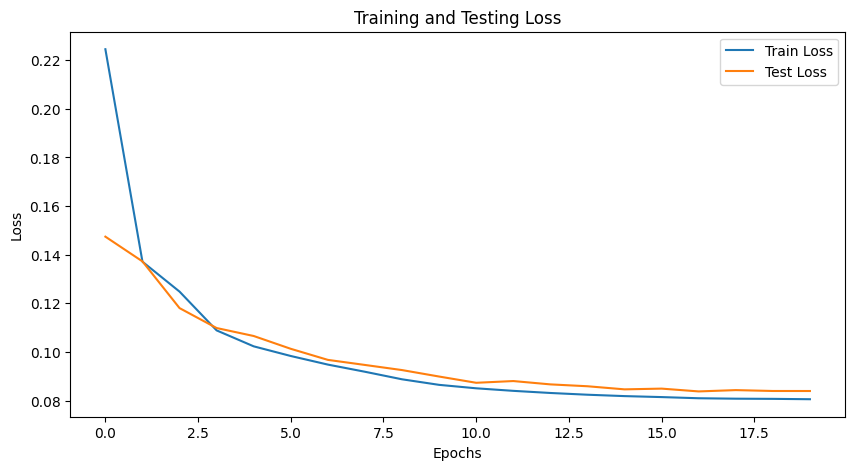

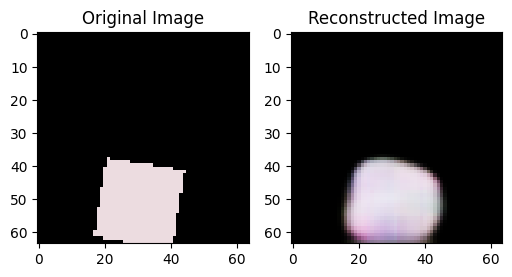

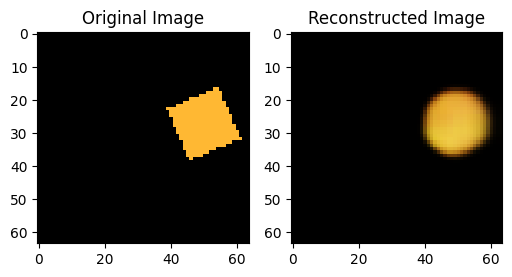

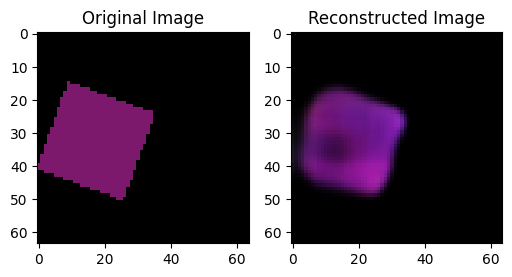

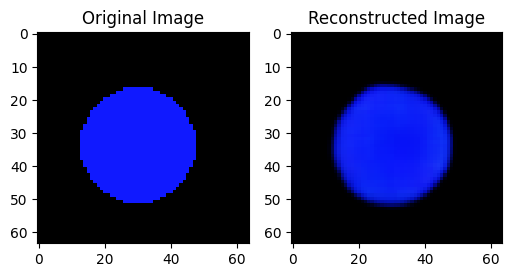

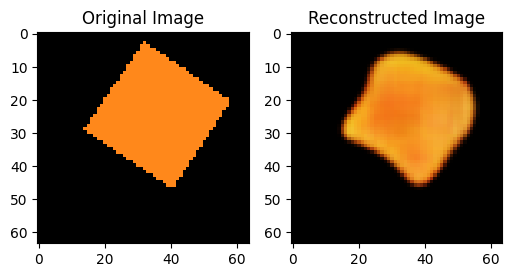

(Autoencoder(
   (encoder): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
     )
     (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (2): Dropout(p=0.1, inplace=False)
     (3): ResidualBlock(
       (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
     )
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): Dropout(p=0.1, inplace=False)
     (6): ResidualBlock(
       (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (relu): ReLU()
       (

In [6]:
train_model(embedding_size=16, dropout_rate=0.1)

Number of parameters: 1291395
Epoch [1/20], Train Loss: 0.2252, Test Loss: 0.1466
Epoch [2/20], Train Loss: 0.1335, Test Loss: 0.1324
Epoch [3/20], Train Loss: 0.1129, Test Loss: 0.1095
Epoch [4/20], Train Loss: 0.1036, Test Loss: 0.1096
Epoch [5/20], Train Loss: 0.0982, Test Loss: 0.0994
Epoch [6/20], Train Loss: 0.0921, Test Loss: 0.0953
Epoch [7/20], Train Loss: 0.0874, Test Loss: 0.0910
Epoch [8/20], Train Loss: 0.0846, Test Loss: 0.0870
Epoch [9/20], Train Loss: 0.0827, Test Loss: 0.0849
Epoch [10/20], Train Loss: 0.0813, Test Loss: 0.0830
Epoch [11/20], Train Loss: 0.0799, Test Loss: 0.0831
Epoch [12/20], Train Loss: 0.0790, Test Loss: 0.0816
Epoch [13/20], Train Loss: 0.0783, Test Loss: 0.0802
Epoch [14/20], Train Loss: 0.0776, Test Loss: 0.0799
Epoch [15/20], Train Loss: 0.0770, Test Loss: 0.0799
Epoch [16/20], Train Loss: 0.0768, Test Loss: 0.0797
Epoch [17/20], Train Loss: 0.0764, Test Loss: 0.0795
Epoch [18/20], Train Loss: 0.0762, Test Loss: 0.0794
Epoch [19/20], Train Loss

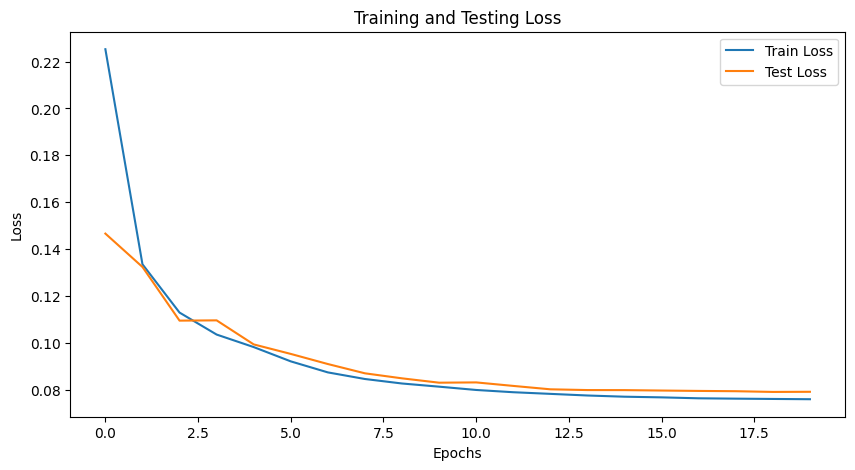

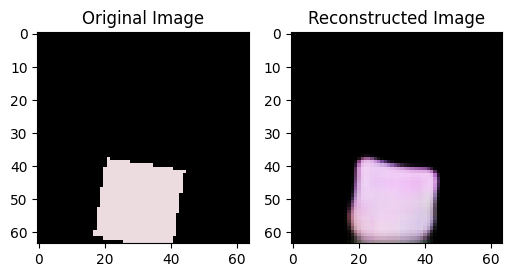

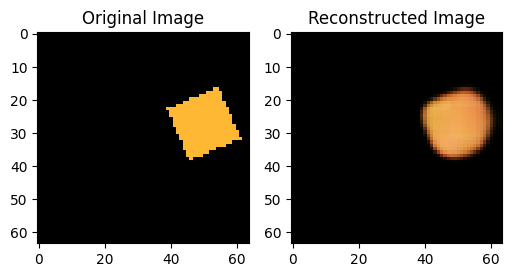

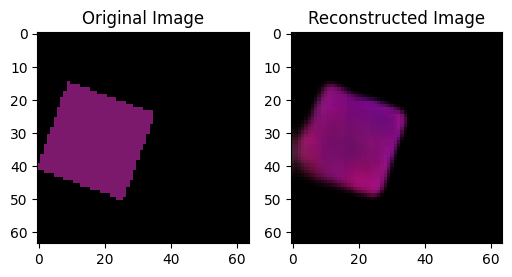

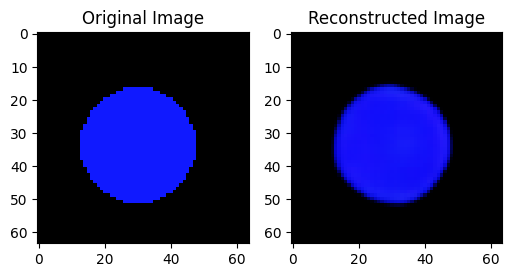

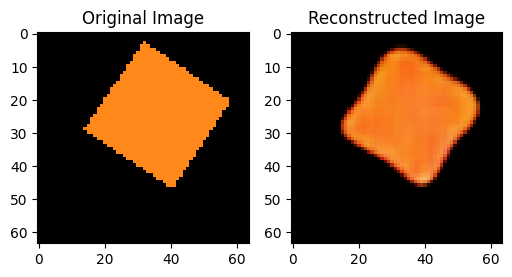

(Autoencoder(
   (encoder): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
     )
     (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (2): Dropout(p=0.1, inplace=False)
     (3): ResidualBlock(
       (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
     )
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): Dropout(p=0.1, inplace=False)
     (6): ResidualBlock(
       (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (relu): ReLU()
       (

In [7]:
train_model(embedding_size=32, dropout_rate=0.1)

Number of parameters: 1815715
Epoch [1/20], Train Loss: 0.2106, Test Loss: 0.1432
Epoch [2/20], Train Loss: 0.1310, Test Loss: 0.1201
Epoch [3/20], Train Loss: 0.1080, Test Loss: 0.1038
Epoch [4/20], Train Loss: 0.0939, Test Loss: 0.0924
Epoch [5/20], Train Loss: 0.0873, Test Loss: 0.0881
Epoch [6/20], Train Loss: 0.0843, Test Loss: 0.0858
Epoch [7/20], Train Loss: 0.0820, Test Loss: 0.0836
Epoch [8/20], Train Loss: 0.0802, Test Loss: 0.0829
Epoch [9/20], Train Loss: 0.0789, Test Loss: 0.0808
Epoch [10/20], Train Loss: 0.0777, Test Loss: 0.0795
Epoch [11/20], Train Loss: 0.0770, Test Loss: 0.0788
Epoch [12/20], Train Loss: 0.0760, Test Loss: 0.0781
Epoch [13/20], Train Loss: 0.0757, Test Loss: 0.0777
Epoch [14/20], Train Loss: 0.0751, Test Loss: 0.0771
Epoch [15/20], Train Loss: 0.0747, Test Loss: 0.0769
Epoch [16/20], Train Loss: 0.0744, Test Loss: 0.0768
Epoch [17/20], Train Loss: 0.0741, Test Loss: 0.0766
Epoch [18/20], Train Loss: 0.0740, Test Loss: 0.0763
Epoch [19/20], Train Loss

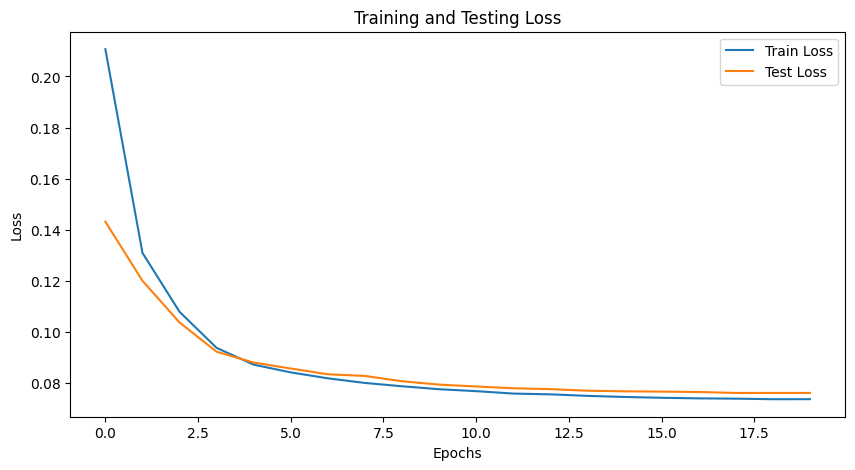

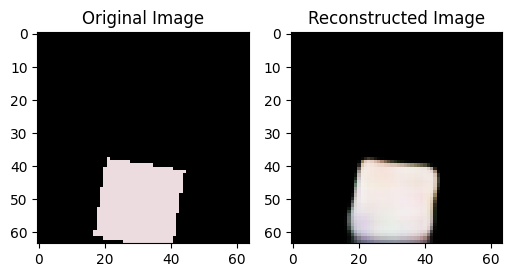

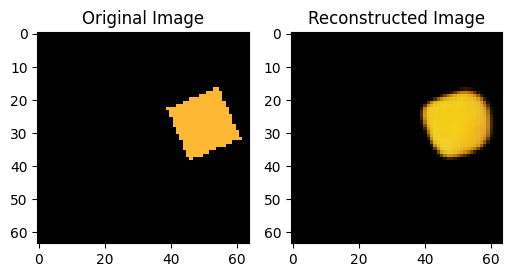

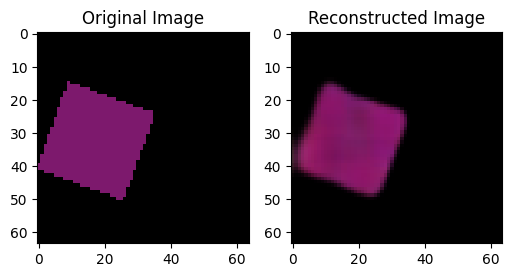

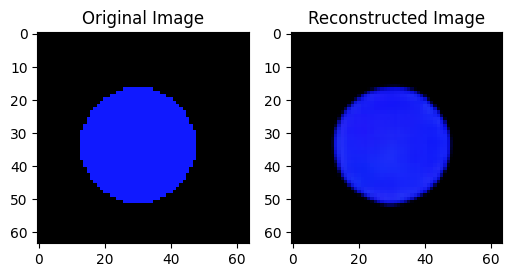

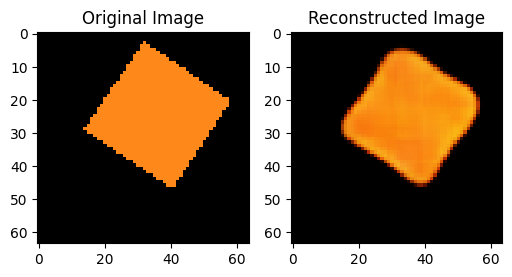

(Autoencoder(
   (encoder): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
     )
     (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (2): Dropout(p=0.1, inplace=False)
     (3): ResidualBlock(
       (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
     )
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): Dropout(p=0.1, inplace=False)
     (6): ResidualBlock(
       (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (relu): ReLU()
       (

In [8]:
train_model(embedding_size=64, dropout_rate=0.1)